In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print("complete")

complete


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [4]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")

Image shape: torch.Size([3, 32, 32])
Label: 6
Number of classes: 10


In [5]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))


In [6]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성해봅시다.
transform = transforms.Compose([
    transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
])

In [7]:
num_classes = len(trainset.classes)
print(num_classes)

10


In [8]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

In [10]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

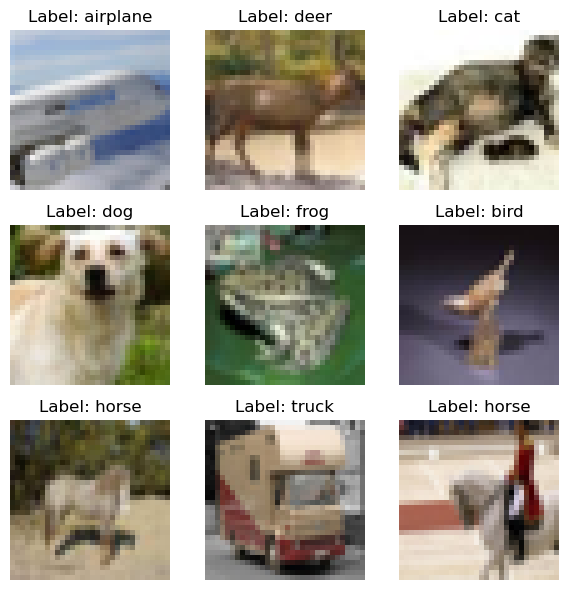

In [11]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

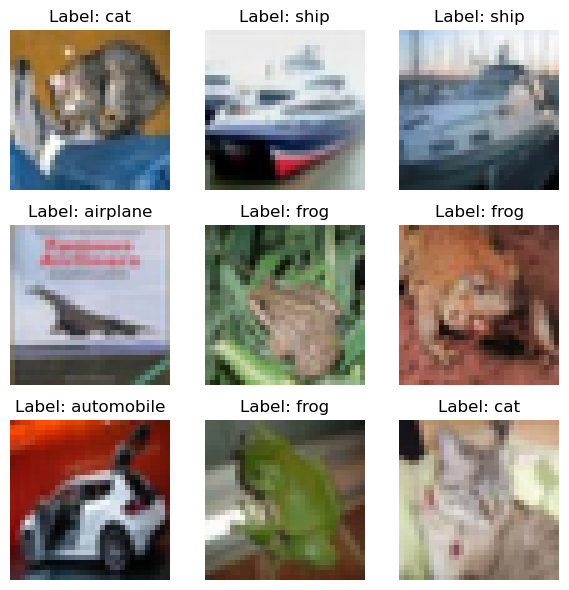

In [12]:
# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

BasicBlock: ResNet-34

In [49]:
class BasicBlock(nn.Module):
    """
    BasicBlock for ResNet-34
    구조: 3x3 conv -> BN -> ReLU -> 3x3 conv -> BN -> (+identity) -> ReLU
    """
    expansion = 1  # 출력 채널이 입력 채널과 동일
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        # 첫 번째 3x3 convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 두 번째 3x3 convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Shortcut connection
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

Bottleneck: ResNet-50

In [50]:
class Bottleneck(nn.Module):
    """
    Bottleneck block for ResNet-50
    구조: 1x1 conv -> BN -> ReLU -> 3x3 conv -> BN -> ReLU -> 1x1 conv -> BN -> (+identity) -> ReLU
    """
    expansion = 4  # 출력 채널이 입력 채널의 4배
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        
        # 1x1 convolution: 채널 축소
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3 convolution: spatial feature 추출
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1x1 convolution: 채널 확장 (4배)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        # Bottleneck path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Shortcut connection
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

ResNet 기본 클래스

In [51]:
class ResNet(nn.Module):
    """
    ResNet 구조 (논문 Table 1 기반)
    - conv1: 7×7, 64, stride 2 (CIFAR-10용으로 3x3, stride 1로 수정)
    - conv2_x: [3×3, 64] × 블록 수
    - conv3_x: [3×3, 128] × 블록 수
    - conv4_x: [3×3, 256] × 블록 수
    - conv5_x: [3×3, 512] × 블록 수
    - average pool, fc
    """
    
    def __init__(self, block, layers, num_classes=10):
        """
        Args:
            block: BasicBlock 또는 Bottleneck
            layers: 각 레이어의 블록 개수 [3, 4, 6, 3]
            num_classes: 분류할 클래스 수 (CIFAR-10은 10)
        """
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # conv1: CIFAR-10용으로 7x7 대신 3x3, stride 1 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # ImageNet용 ResNet은 여기에 MaxPool이 있지만, CIFAR-10은 이미지가 작아서 생략
        
        # conv2_x, conv3_x, conv4_x, conv5_x (논문 Table 1 참조)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)   # 64 channels, stride=1
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # 128 channels, stride=2
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # 256 channels, stride=2
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # 512 channels, stride=2
        
        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected layer
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # 가중치 초기화
        self._initialize_weights()
        
    def _make_layer(self, block, out_channels, blocks, stride=1):
        """
        하나의 레이어(여러 블록으로 구성) 생성
        
        Args:
            block: BasicBlock 또는 Bottleneck
            out_channels: 출력 채널 수
            blocks: 이 레이어에 포함될 블록 개수
            stride: 첫 번째 블록의 stride
        """
        downsample = None
        
        # stride가 1이 아니거나 채널 수가 변경되는 경우 downsample 필요
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        
        layers = []
        # 첫 번째 블록 (stride 적용, downsample 가능)
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        
        # 나머지 블록들 (stride=1, downsample 없음)
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        """가중치 초기화 (Kaiming initialization)"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # conv1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # ImageNet용 ResNet은 여기에 MaxPool이 있음
        
        # conv2_x, conv3_x, conv4_x, conv5_x
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global Average Pooling & FC
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

ResNet-34 및 ResNet-50 생성 함수

In [52]:
def ResNet34(num_classes=10):
    """
    ResNet-34 (논문 Table 1)
    - 구조: [3, 4, 6, 3] BasicBlocks
    - conv2_x: 3개 블록 (64 channels)
    - conv3_x: 4개 블록 (128 channels)
    - conv4_x: 6개 블록 (256 channels)
    - conv5_x: 3개 블록 (512 channels)
    - 총 34 layers: 1(conv1) + 2×(3+4+6+3) + 1(fc) = 34
    """
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes=10):
    """
    ResNet-50 (논문 Table 1)
    - 구조: [3, 4, 6, 3] Bottlenecks
    - conv2_x: 3개 블록 (64→256 channels)
    - conv3_x: 4개 블록 (128→512 channels)
    - conv4_x: 6개 블록 (256→1024 channels)
    - conv5_x: 3개 블록 (512→2048 channels)
    - 총 50 layers: 1(conv1) + 3×(3+4+6+3) + 1(fc) = 50
    """
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

In [53]:
print("\n" + "="*70)
print("ResNet-34 모델 생성")
print("="*70)
model_34 = ResNet34(num_classes=num_classes)
print(model_34)

total_params_34 = sum(p.numel() for p in model_34.parameters())
print(f"\n총 파라미터 수: {total_params_34:,}")

print("\n" + "="*70)
print("ResNet-50 모델 생성")
print("="*70)
model_50 = ResNet50(num_classes=num_classes)
print(model_50)

total_params_50 = sum(p.numel() for p in model_50.parameters())
print(f"\n총 파라미터 수: {total_params_50:,}")


ResNet-34 모델 생성
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): 

학습 함수

In [54]:
def train_model(model, trainloader, testloader, epochs=10, device='cuda'):
    """
    모델 학습 함수 (학습 이력 저장 기능 추가)
    """
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225], gamma=0.1)
    
    # 학습 이력 저장을 위한 리스트
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    print(f"\n학습 시작 (device: {device})")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100. * correct / total
        
        # Validation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        test_loss = test_loss / len(testloader)
        test_acc = 100. * correct / total
        
        # 이력 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{epochs}] '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    return history

In [55]:
def plot_training_history(history_34, history_50):
    """
    ResNet-34와 ResNet-50의 학습 결과를 시각화
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history_34['train_loss']) + 1)
    
    # Training Loss
    axes[0, 0].plot(epochs, history_34['train_loss'], 'r-', label='ResNet-34', linewidth=2)
    axes[0, 0].plot(epochs, history_50['train_loss'], 'b-', label='ResNet-50', linewidth=2)
    axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Training Accuracy
    axes[0, 1].plot(epochs, history_34['train_acc'], 'r-', label='ResNet-34', linewidth=2)
    axes[0, 1].plot(epochs, history_50['train_acc'], 'b-', label='ResNet-50', linewidth=2)
    axes[0, 1].set_title('Training Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Test Loss
    axes[1, 0].plot(epochs, history_34['test_loss'], 'r-', label='ResNet-34', linewidth=2)
    axes[1, 0].plot(epochs, history_50['test_loss'], 'b-', label='ResNet-50', linewidth=2)
    axes[1, 0].set_title('Test Loss', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Test Accuracy
    axes[1, 1].plot(epochs, history_34['test_acc'], 'r-', label='ResNet-34', linewidth=2)
    axes[1, 1].plot(epochs, history_50['test_acc'], 'b-', label='ResNet-50', linewidth=2)
    axes[1, 1].set_title('Test Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



ResNet-34 학습 시작

학습 시작 (device: cuda)
Epoch [1/10] Train Loss: 2.5212, Train Acc: 13.58% | Test Loss: 2.1449, Test Acc: 18.93%
Epoch [2/10] Train Loss: 1.7255, Train Acc: 34.57% | Test Loss: 1.5653, Test Acc: 41.97%
Epoch [3/10] Train Loss: 1.4014, Train Acc: 48.49% | Test Loss: 1.3320, Test Acc: 50.99%
Epoch [4/10] Train Loss: 1.1526, Train Acc: 58.45% | Test Loss: 1.1299, Test Acc: 59.67%
Epoch [5/10] Train Loss: 0.9359, Train Acc: 66.50% | Test Loss: 0.9405, Test Acc: 66.89%
Epoch [6/10] Train Loss: 0.7928, Train Acc: 71.76% | Test Loss: 0.9590, Test Acc: 66.50%
Epoch [7/10] Train Loss: 0.6646, Train Acc: 76.54% | Test Loss: 0.9002, Test Acc: 69.86%
Epoch [8/10] Train Loss: 0.5553, Train Acc: 80.47% | Test Loss: 0.8266, Test Acc: 73.08%
Epoch [9/10] Train Loss: 0.4863, Train Acc: 82.97% | Test Loss: 0.8661, Test Acc: 73.03%
Epoch [10/10] Train Loss: 0.4128, Train Acc: 85.55% | Test Loss: 0.6348, Test Acc: 78.40%

ResNet-50 학습 시작

학습 시작 (device: cuda)
Epoch [1/10] Train Loss: 3.4718

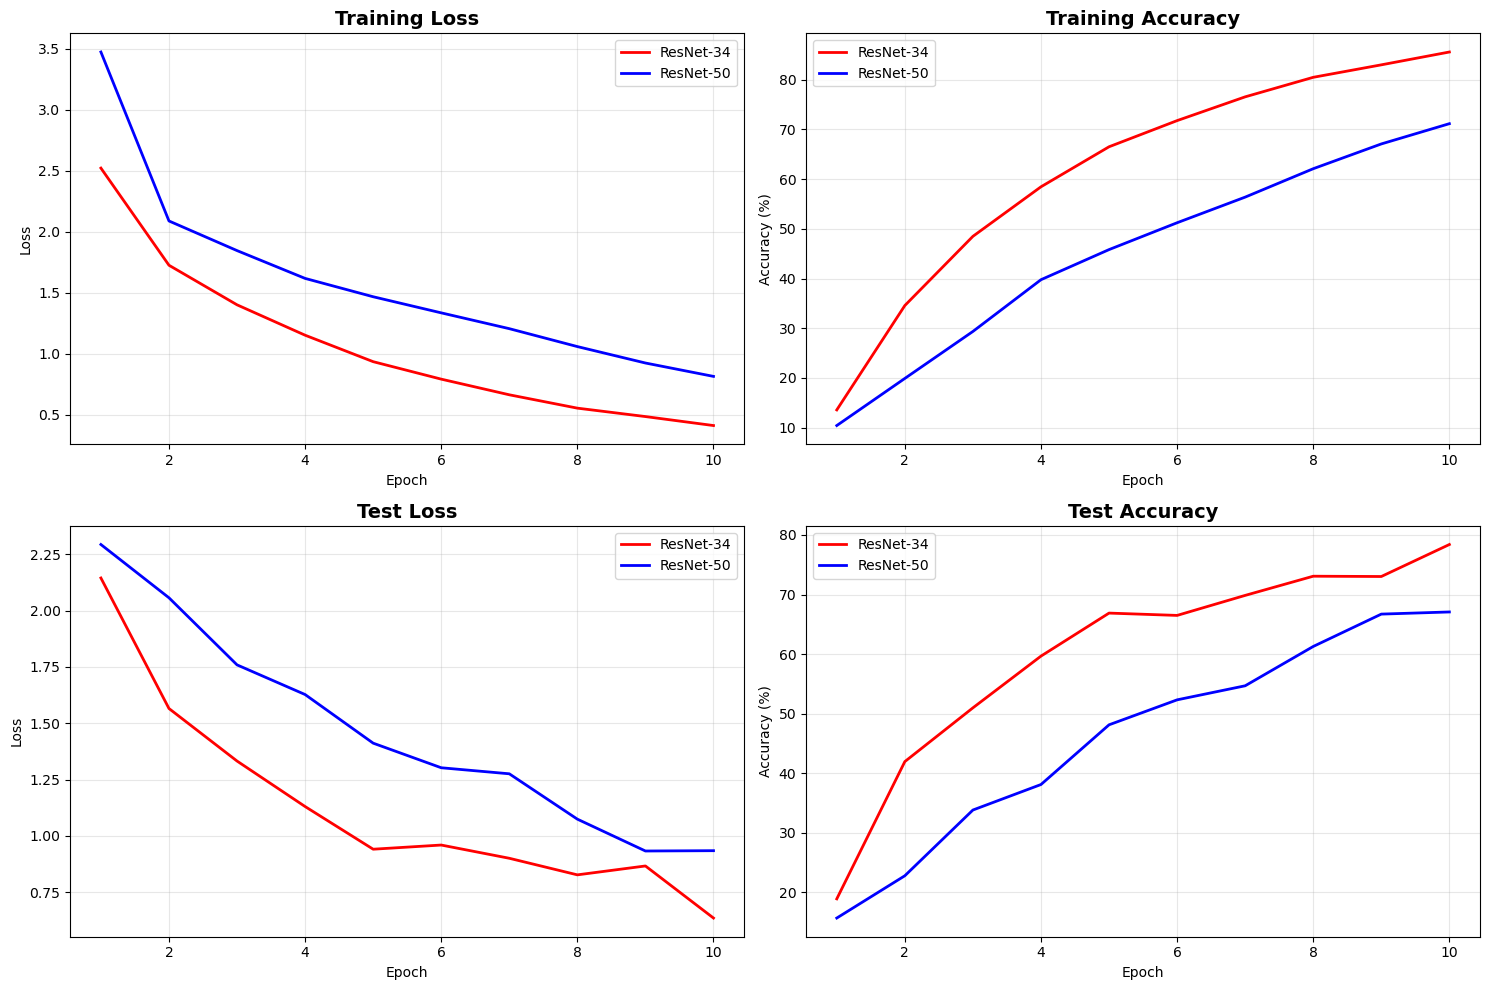


최종 결과 요약
ResNet-34 - 최종 Test Accuracy: 78.40%
ResNet-50 - 최종 Test Accuracy: 67.08%


In [56]:
# ResNet-34 학습
print("\n" + "="*70)
print("ResNet-34 학습 시작")
print("="*70)
history_34 = train_model(model_34, trainloader, testloader, epochs=10)

# ResNet-50 학습
print("\n" + "="*70)
print("ResNet-50 학습 시작")
print("="*70)
history_50 = train_model(model_50, trainloader, testloader, epochs=10)

# 결과 시각화
print("\n" + "="*70)
print("학습 결과 시각화")
print("="*70)
plot_training_history(history_34, history_50)

# 최종 결과 출력
print("\n" + "="*70)
print("최종 결과 요약")
print("="*70)
print(f"ResNet-34 - 최종 Test Accuracy: {history_34['test_acc'][-1]:.2f}%")
print(f"ResNet-50 - 최종 Test Accuracy: {history_50['test_acc'][-1]:.2f}%")S

residual 모델은 안정적으로 수혐하며 성능이 점점 좋아지는 것을 확인했습니다.